In [4]:
# import quadpy,latexify
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
kB = 8.61733e-5 # eV / K
me_c2 = 510998.92 # eV
h = 4.13567e-15 # eV s

In [5]:
#@latexify.function(use_math_symbols=True,reduce_assignments=False)
def Ne(i_gamma, Te, gamma_th, Ce=1, n=3):
    Theta = kB * Te / me_c2

    return Ce*i_gamma**2*np.exp(-i_gamma/Theta)/(2.*Theta**3) if i_gamma <= gamma_th else Ce*gamma_th**2*np.exp(-gamma_th/Theta)*(i_gamma/gamma_th)**-n/(2.*Theta**3)
#Ne

In [6]:
gamma = np.linspace(1, 100, 1000)

In [7]:
Te=widgets.FloatSlider(description='Te',min=1e8, max=1e11, step=1e8, value=1e10)
gamma_th=widgets.FloatSlider(description='gamma_th',min=1, max=100, step=1, value=20)
ui = widgets.VBox([Te, gamma_th])

def electron_dist_img(Te, gamma_th):
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111)

    Ne_arr = np.zeros_like(gamma)
    for i, i_gamma in enumerate(gamma):
        Ne_arr[i] = Ne(i_gamma, Te=Te, gamma_th=gamma_th)

    ax.plot(gamma, Ne_arr,label=f'$T_\mathrm{{e}} = 10^{{{np.log10(Te):.1f}}}$ K')

    ax.axvline(gamma_th, color='k', linestyle='--', label=r'$\gamma_\mathrm{th}$')

    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(r'$N_\mathrm{e}/C_\mathrm{e}$')
    ax.set_yscale('log')
    ax.set_ylim(1e-13, 1e2)
    ax.legend()

out = widgets.interactive_output(electron_dist_img, {'Te': Te, 'gamma_th': gamma_th})
display(ui, out)

Output()

In [8]:
#@latexify.function(use_math_symbols=True)
def beta(i_gamma):
    return np.sqrt(1 - 1/i_gamma**2)
#beta

In [9]:
#@latexify.function(use_math_symbols=True,reduce_assignments=False)
def e1(nu,theta,theta2,i_gamma,phi2):
    e0 = h*nu
    cos_theta1 = np.cos(theta)*np.cos(theta2)+np.sin(theta)*np.sin(theta2)*np.sin(phi2)
    
    return e0*(1-beta(i_gamma)*np.cos(theta2))/(e0/(i_gamma*me_c2)*(1-np.cos(theta))+1-beta(i_gamma)*cos_theta1)
#e1

In [10]:
Te=widgets.FloatSlider(description='Te',min=1e8, max=1e11, step=1e8, value=1e10)
gamma_th=widgets.FloatSlider(description='gamma_th',min=1, max=100, step=1, value=20)
nu=widgets.FloatSlider(description='nu',min=1e13, max=1e16, step=1e13, value=1e15)
theta=widgets.FloatSlider(description='theta',min=0, max=np.pi, step=np.pi/16, value=np.pi/4)
ui = widgets.VBox([Te, gamma_th, nu, theta])


#被积函数
# scheme = quadpy.u3.get_good_scheme(47)
def func(theta2_phi2,nu,theta,i_gamma):
    theta2, phi2 = theta2_phi2
    #val, error_estimate = quadpy.c1.integrate_adaptive(
    #    lambda i_gamma: Ne(i_gamma,Te=Te,gamma_th=gamma_th)*e1(nu,theta,theta2,#i_gamma,phi2) , [1, 10]
    #)
    return e1(nu,theta,theta2,i_gamma,phi2)

#
#
#np.sum(val)

#@latexify.function(use_math_symbols=True,reduce_assignments=True)
#def mean_e1(nu, theta):
#    return quadpy.quad(e1, 0, 2*np.pi, args=(theta,theta,gamma,0))
#mean_e1

def calc_img(Te, gamma_th, nu, theta):
    print(Te, gamma_th, nu, theta)
    #val = scheme.integrate_spherical(func,)
    #print(val)

# out = widgets.interactive_output(calc_img, {'Te': Te, 'gamma_th': gamma_th, 'nu':nu, 'theta':theta})
# display(ui, out)

In [11]:
def func(theta2_phi2,nu,theta,i_gamma):
    theta2, phi2 = theta2_phi2
    #val, error_estimate = quadpy.c1.integrate_adaptive(
    #    lambda i_gamma: Ne(i_gamma,Te=Te,gamma_th=gamma_th)*e1(nu,theta,theta2,#i_gamma,phi2) , [1, 10]
    #)
    return e1(nu,theta,theta2,i_gamma,phi2)

In [12]:
def func(theta2_phi2,x):
    theta2, phi2 = theta2_phi2
    #val, error_estimate = quadpy.c1.integrate_adaptive(
    #    lambda i_gamma: Ne(i_gamma,Te=Te,gamma_th=gamma_th)*e1(nu,theta,theta2,#i_gamma,phi2) , [1, 10]
    #)
    #print(theta2.shape)
    return x*np.linspace(0,1,theta2.shape[0])*np.sin(theta2)
#val = scheme.integrate_spherical(func)
#val

In [13]:
import numpy as np
import quadpy

scheme = quadpy.u3.get_good_scheme(19)
# scheme.show()
val = scheme.integrate(lambda x: np.exp(x[0]), [0.0, 0.0, 0.0], 1.0)
val

14.76801374576529

In [38]:
# To avoid copying things to GPU memory,
# ideally allocate everything in torch on the GPU
# and avoid non-torch function calls
import torch
from torchquad import MonteCarlo, set_up_backend

# Enable GPU support if available and set the floating point precision
set_up_backend("torch", data_type="float32")

# The function we want to integrate, in this example
# f(x0,x1) = sin(x0) + e^x1 for x0=[0,1] and x1=[-1,1]
# Note that the function needs to support multiple evaluations at once (first
# dimension of x here)
# Expected result here is ~3.2698
def some_function(x):
    return torch.sin(x[:, 0]) + torch.exp(x[:, 1])

# Declare an integrator;
# here we use the simple, stochastic Monte Carlo integration method
mc = MonteCarlo()

# Compute the function integral by sampling 10000 points over domain
integral_value = mc.integrate(
    some_function,
    dim=2,
    N=10000,
    integration_domain=[[0, 1], [-1, 1]],
    backend="torch",
)
integral_value

14:41:04|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.


tensor(3.2736384869)

In [15]:
import scipy
import numpy as np

# For benchmarking
import time
from scipy.integrate import nquad

# For plotting
import matplotlib.pyplot as plt

# To avoid copying things to GPU memory,
# ideally allocate everything in torch on the GPU
# and avoid non-torch function calls
import torch
torch.set_printoptions(precision=10) # Set displayed output precision to 10 digits

from torchquad import set_up_backend  # Necessary to enable GPU support
from torchquad import Trapezoid, Simpson, Boole, MonteCarlo, VEGAS # The available integrators
from torchquad.utils.set_precision import set_precision
import torchquad

In [16]:
# Use this to enable GPU support and set the floating point precision
set_up_backend("torch", data_type="float32")

14:40:28|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.


In [17]:
def f(x):

    return torch.exp(x) * torch.pow(x, 2)

def print_error(result, solution):
    print("Results:", result.item())
    print(f"Abs. Error: {(torch.abs(result - solution).item()):.8e}")
    print(f"Rel. Error: {(torch.abs((result - solution) / solution).item()):.8e}")

solution = 2 * (torch.exp(torch.tensor([2.0])) - 1)

Text(0, 0.5, 'f($x$)')

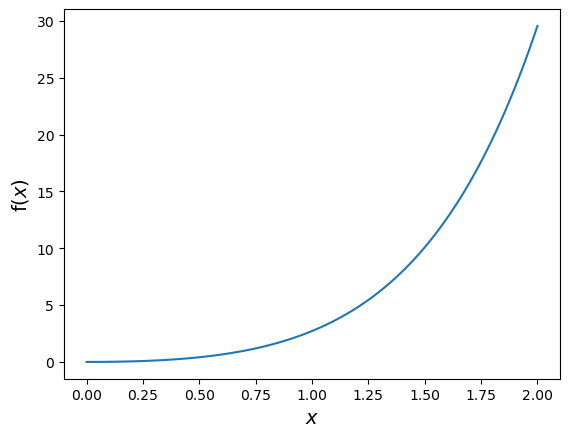

In [18]:
points = torch.linspace(0, 2, 100)
# Note that for plotting we have to move the values to the CPU first
plt.plot(points.cpu(), f(points).cpu())
plt.xlabel("$x$", fontsize=14)
plt.ylabel("f($x$)", fontsize=14)

In [19]:
# Integration domain is a list of lists to allow arbitrary dimensionality.
integration_domain = [[0, 2]]
# Initialize a trapezoid solver
tp = Trapezoid()

In [39]:
result = tp.integrate(f, dim=1, N=101, integration_domain=integration_domain)
print_error(result, solution)

Results: 0.718349814414978
Abs. Error: 3.87862730e+00
Rel. Error: 8.43734264e-01


In [21]:
simp = Simpson()
result = simp.integrate(f, dim=1, N=101, integration_domain=integration_domain)
print_error(result, solution)

Results: 12.778112411499023
Abs. Error: 0.00000000e+00
Rel. Error: 0.00000000e+00


In [22]:
mc = MonteCarlo()
result = mc.integrate(f, dim=1, N=101, integration_domain=integration_domain)
print_error(result, solution)

Results: 12.366924285888672
Abs. Error: 4.11188126e-01
Rel. Error: 3.21790986e-02


In [23]:
vegas = VEGAS()
result = vegas.integrate(f, dim=1, N=1001, integration_domain=integration_domain)
print_error(result, solution)

Results: 12.842772483825684
Abs. Error: 6.46600723e-02
Rel. Error: 5.06022107e-03


In [41]:
def f_2(x):
    return torch.sum(torch.sin(x), dim=1)


solution = 20 * (torch.sin(torch.tensor([0.5])) * torch.sin(torch.tensor([0.5])))

In [42]:
# Integration domain is a list of lists to allow arbitrary dimensionality
integration_domain = [[0, 1]] * 10
N = 3 ** 10

In [26]:
tp = Trapezoid()  # Initialize a trapezoid solver
result = tp.integrate(f_2, dim=10, N=N, integration_domain=integration_domain)
print_error(result, solution)

Results: 4.500804424285889
Abs. Error: 9.61728096e-02
Rel. Error: 2.09208801e-02


In [27]:
simp = Simpson()  # Initialize Simpson solver
result = simp.integrate(f_2, dim=10, N=N, integration_domain=integration_domain)
print_error(result, solution)

Results: 4.598623275756836
Abs. Error: 1.64604187e-03
Rel. Error: 3.58070480e-04


In [43]:
boole = Boole()  # Initialize Boole solver
result = boole.integrate(f_2, dim=10, N=N, integration_domain=integration_domain)
print_error(result,solution)

Results: 4.596974849700928
Abs. Error: 2.38418579e-06
Rel. Error: 5.18642082e-07


In [29]:
mc = MonteCarlo()
result = mc.integrate(f_2, dim=10, N=N, integration_domain=integration_domain, seed=42)
print_error(result, solution)

Results: 4.596116065979004
Abs. Error: 8.61167908e-04
Rel. Error: 1.87333513e-04


In [30]:
vegas = VEGAS()
result = vegas.integrate(f_2, dim=10, N=N, integration_domain=integration_domain)
print_error(result, solution)

Results: 4.59611701965332
Abs. Error: 8.60214233e-04
Rel. Error: 1.87126061e-04


In [31]:
import torch
from torchquad import MonteCarlo, Trapezoid, set_up_backend

def test_function(x):
    """V shaped test function."""
    return 2 * torch.abs(x)

set_up_backend("torch", data_type="float64")
# Number of function evaluations
N = 10000

# Calculate a gradient with the MonteCarlo integrator
# Define the integrator
integrator_mc = MonteCarlo()
# Integration domain
domain = torch.tensor([[-1.0, 1.0]])
# Enable the creation of a computational graph for gradient calculation.
domain.requires_grad = True
# Calculate the 1-D integral by using the previously defined test_function
# with MonteCarlo; set a RNG seed to get reproducible results
result_mc = integrator_mc.integrate(
    test_function, dim=1, N=N, integration_domain=domain, seed=0
)
# Compute the gradient with a backward pass
result_mc.backward()
gradient_mc = domain.grad

# Calculate a gradient analogously with the composite Trapezoid integrator
integrator_tp = Trapezoid()
domain = torch.tensor([[-1.0, 1.0]])
domain.requires_grad = True
result_tp = integrator_tp.integrate(
    test_function, dim=1, N=N, integration_domain=domain
)
result_tp.backward()
gradient_tp = domain.grad

# Show the results
print(f"Gradient result for MonteCarlo: {gradient_mc}")
print(f"Gradient result for Trapezoid: {gradient_tp}")

14:40:33|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.


Gradient result for MonteCarlo: tensor([[-1.9827745807,  2.0195745807]])
Gradient result for Trapezoid: tensor([[-2.0000000200,  2.0000000200]])


In [44]:
import time
import torch
from torchquad import Boole, set_up_backend


def example_integrand(x):
    return torch.sum(torch.sin(x), dim=1)


set_up_backend("torch", data_type="float32")
N = 912673
dim = 3
integrator = Boole()
domains = [torch.tensor([[-1.0, y]] * dim) for y in range(5)]

# Integrate without compilation
times_uncompiled = []
for integration_domain in domains:
    t0 = time.perf_counter()
    integrator.integrate(example_integrand, dim, N, integration_domain)
    times_uncompiled.append(time.perf_counter() - t0)

# Integrate with partial compilation
integrate_jit_compiled_parts = integrator.get_jit_compiled_integrate(
    dim, N, backend="torch"
)
times_compiled_parts = []
for integration_domain in domains:
    t0 = time.perf_counter()
    integrate_jit_compiled_parts(example_integrand, integration_domain)
    times_compiled_parts.append(time.perf_counter() - t0)

# Integrate with everything compiled
times_compiled_all = []
integrate_compiled = None
for integration_domain in domains:
    t0 = time.perf_counter()
    if integrate_compiled is None:
        integrate_compiled = torch.jit.trace(
            lambda dom: integrator.integrate(example_integrand, dim, N, dom),
            (integration_domain,),
        )
    integrate_compiled(integration_domain)
    times_compiled_all.append(time.perf_counter() - t0)

print(f"Uncompiled times: {times_uncompiled}")
print(f"Partly compiled times: {times_compiled_parts}")
print(f"All compiled times: {times_compiled_all}")
speedups = [
    (1.0, tu / tcp, tu / tca)
    for tu, tcp, tca in zip(times_uncompiled, times_compiled_parts, times_compiled_all)
]
print(f"Speedup factors: {speedups}")

14:41:41|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.


Uncompiled times: [0.025103393010795116, 0.01334410603158176, 0.013418554794043303, 0.013149826088920236, 0.02274630288593471]
Partly compiled times: [0.24252887489274144, 0.013059029821306467, 0.013157336041331291, 0.013171280967071652, 0.013813274912536144]
All compiled times: [0.17178457602858543, 0.014636202016845345, 0.013542275177314878, 0.013357521034777164, 0.013316778931766748]
Speedup factors: [(1.0, 0.10350682170070309, 0.14613298580786346), (1.0, 1.0218298153979384, 0.9117191752493943), (1.0, 1.0198534682014233, 0.9908641360737652), (1.0, 0.9983710864413982, 0.9844510859974556), (1.0, 1.6466987756315092, 1.708093451313075)]


In [33]:
import torch
from torchquad import Boole

def integrand1(x):
    return torch.sin(x[:, 0]) + torch.exp(x[:, 1])

def integrand2(x):
    return torch.prod(torch.cos(x), dim=1)

# The integration domain, dimensionality and number of evaluations
# For the calculate_grid method we need a Tensor and not a list.
integration_domain = torch.Tensor([[0.0, 1.0], [-1.0, 1.0]])
dim = 2
N = 9409

# Initialize the integrator
integrator = Boole()
# Calculate sample points and grid information for the result calculation
grid_points, hs, n_per_dim = integrator.calculate_grid(N, integration_domain)

# Integrate the first integrand with the sample points
function_values, _ = integrator.evaluate_integrand(integrand1, grid_points)
integral1 = integrator.calculate_result(function_values, dim, n_per_dim, hs, integration_domain)

# Integrate the second integrand with the same sample points
function_values, _ = integrator.evaluate_integrand(integrand2, grid_points)
integral2 = integrator.calculate_result(function_values, dim, n_per_dim, hs, integration_domain)

print(f"Quadrature results: {integral1}, {integral2}")

Quadrature results: 3.2697949409484863, 1.4161455631256104


In [34]:
def parametrized_integrand(x, a, b):
    return torch.sqrt(torch.cos(torch.sin((a + b) * x)))

a_params = torch.arange(40)
b_params = torch.arange(10, 20)
integration_domain = torch.Tensor([[0, 1]])
simp = Simpson()
result = torch.stack([torch.Tensor([simp.integrate(lambda x: parametrized_integrand(x, a, b), dim=1, N=101, integration_domain=integration_domain) for a in a_params]) for b in b_params])

In [35]:
grid = torch.stack([torch.Tensor([a + b for a in a_params]) for b in b_params])

def integrand(x):
    return torch.sqrt(torch.cos(torch.sin(torch.einsum("i,jk->ijk", x.flatten(), grid))))

result_vectorized = simp.integrate(integrand, dim=1, N=101, integration_domain=integration_domain)

torch.all(torch.isclose(result_vectorized, result)) # True!

tensor(True)

In [45]:
import scipy
from torchquad import Gaussian
from autoray import numpy as anp

class GaussHermite(Gaussian):
    """
    Gauss Hermite quadrature rule in torch, for integrals of the form :math:`\\int_{-\\infty}^{+\\infty} e^{-x^{2}} f(x) dx`. It will correctly integrate
    polynomials of degree :math:`2n - 1` or less over the interval
    :math:`[-\\infty, \\infty]` with weight function :math:`f(x) = e^{-x^2}`. See https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature
    """

    def __init__(self):
        super().__init__()
        self.name = "Gauss-Hermite"
        self._root_fn = scipy.special.roots_hermite

    @staticmethod
    def _apply_composite_rule(cur_dim_areas, dim, hs, domain):
        """Apply "composite" rule for gaussian integrals
        cur_dim_areas will contain the areas per dimension
        """
        # We collapse dimension by dimension
        for _ in range(dim):
            cur_dim_areas = anp.sum(cur_dim_areas, axis=len(cur_dim_areas.shape) - 1)
        return cur_dim_areas

gh=GaussHermite()
integral=gh.integrate(lambda x: 1-x,dim=1,N=2000) #integral from -inf to inf of np.exp(-(x**2))*(1-x)
# Computed integral was 1.7724538509055168.
# analytic result = sqrt(pi)
integral

tensor(1.7724538509, dtype=torch.float64)

In [37]:
# conda install "cudatoolkit>=11.1" "pytorch>=1.9=*cuda*" -c conda-forge -c pytorch
# conda install torchquad -c conda-forge